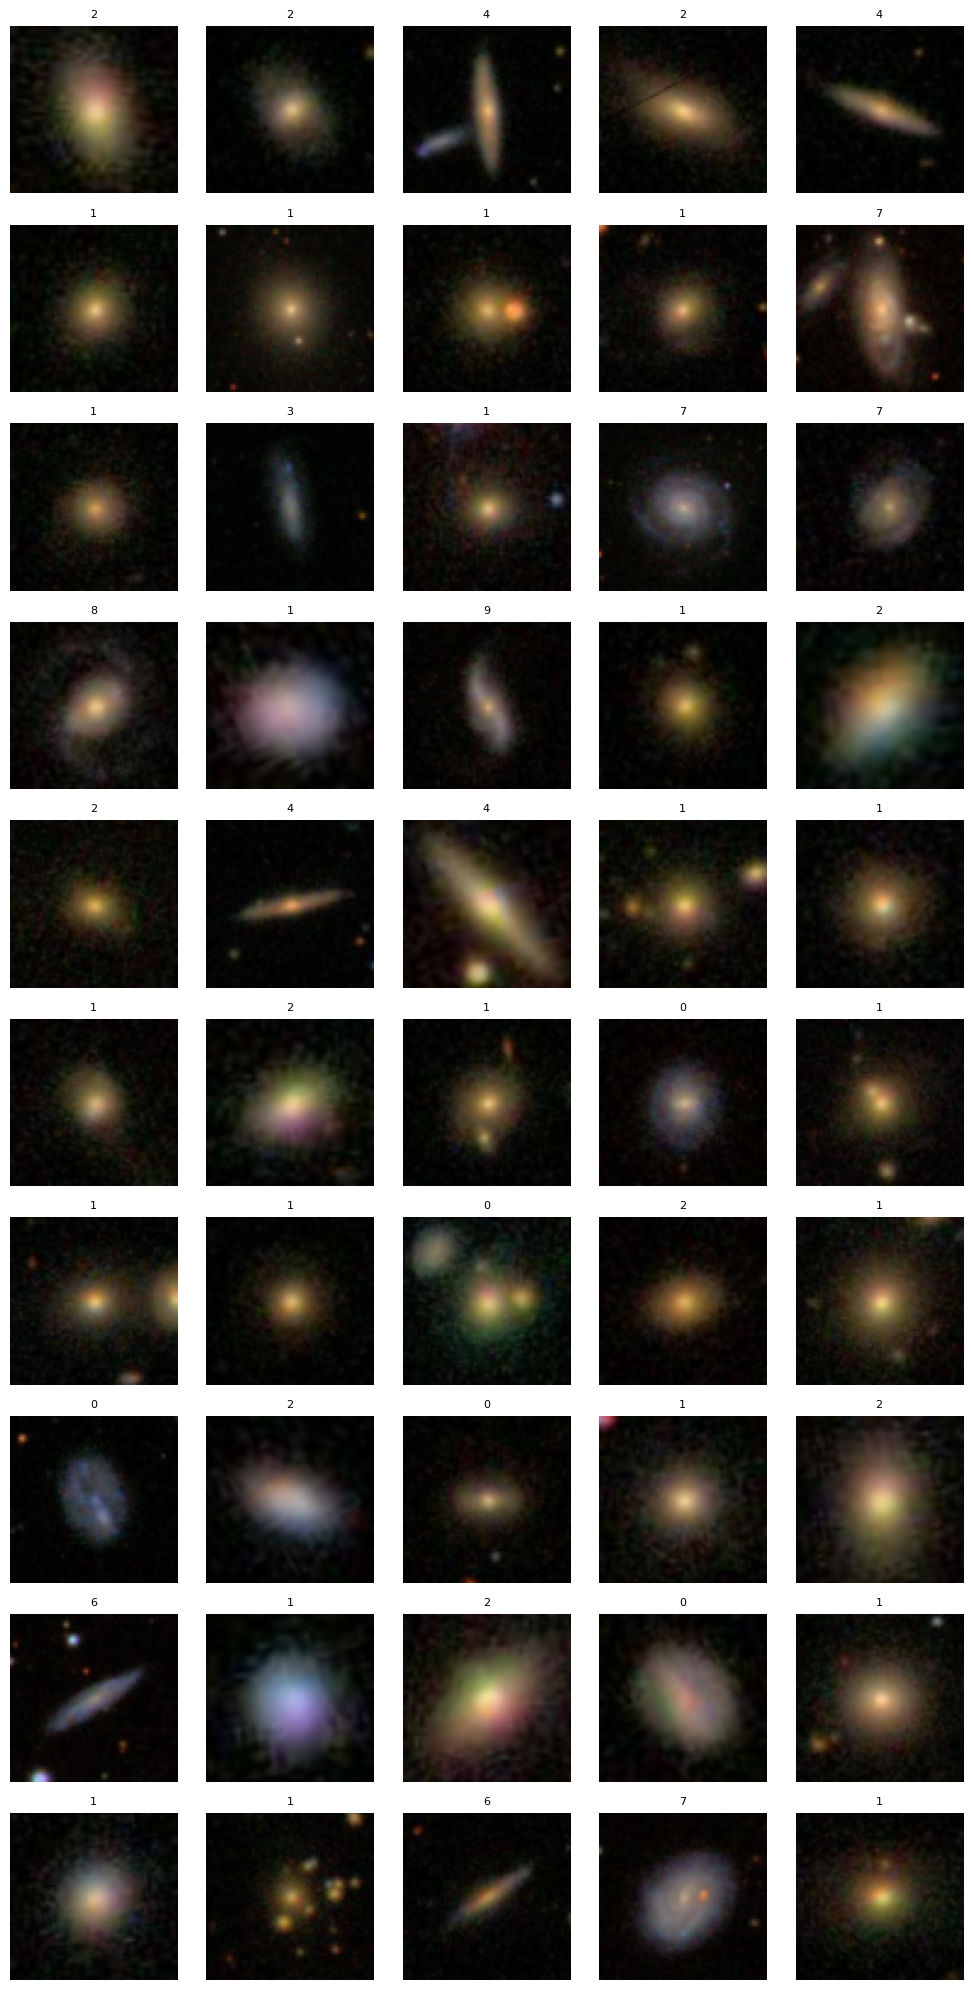

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Galaxy10
class Galaxy10Dataset(Dataset):
    def __init__(self, h5_path):
        with h5py.File(h5_path, 'r') as f:
            self.images = f['images'][:]
            self.labels = f['ans'][:]
        # Convert to torch tensors
        self.images = torch.tensor(self.images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Load the dataset
dataset = Galaxy10Dataset('/Users/siobe/Uni/5ANNO/MACHINELEARNING/ESAME/Galaxy10.h5')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Visualize the first 200 images with labels (from the dataset)
plt.figure(figsize=(10, 20))
for i in range(50):
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy().astype(np.uint8)  # Convert back to HWC for plotting
    plt.subplot(10, 5, i + 1)
    plt.imshow(img)
    plt.title(str(label.item()), fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32 x 34 x 34 (assuming 69x69 input)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64 x 17 x 17

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128 x 8 x 8 (17/2 = 8)

        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256 x 4 x 4

        # Flattening the layer
        self.flatten = nn.Flatten()

        # Fully Connected Layer 1
        # Input features: 256 * 4 * 4 = 4096
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layer 2 (Output Layer)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Conv Layer 1
        x = self.pool1(self.relu1(self.conv1(x)))
        # Conv Layer 2
        x = self.pool2(self.relu2(self.conv2(x)))
        # Conv Layer 3
        x = self.pool3(self.relu3(self.conv3(x)))
        # Conv Layer 4
        x = self.pool4(self.relu4(self.conv4(x)))
        
        # Flatten
        x = self.flatten(x)
        
        # FC Layer 1
        x = self.dropout(self.relu5(self.fc1(x)))
        # FC Layer 2 (Output)
        x = self.fc2(x)
        return x

# Instantiate the model
model = AdvancedCNN(num_classes=10)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)
print(f"Model moved to {device}")

# Example of a forward pass with a dummy input
# Assuming input images are 69x69. From Galaxy10Dataset, images are (N, C, H, W) = (N, 3, 69, 69)
dummy_input = torch.randn(1, 3, 69, 69).to(device) # Batch size of 1
output = model(dummy_input)
print(f"Output shape: {output.shape}") # Expected: torch.Size([1, 10])

AdvancedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Model moved to cpu
Output sh

In [32]:
from torch.utils.data import random_split

# Define the sizes for training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Original dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"Training Dataloader: {len(train_dataloader)} batches of size 16")
print(f"Testing Dataloader: {len(test_dataloader)} batches of size 16")

Original dataset size: 21785
Training dataset size: 17428
Testing dataset size: 4357
Training Dataloader: 1090 batches of size 16
Testing Dataloader: 273 batches of size 16


In [33]:
import torch.optim as optim

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10  # You can adjust the number of epochs

model.train() # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Move inputs and labels to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Finished Training")

Epoch [1/10], Loss: 1.2888
Epoch [2/10], Loss: 0.9867
Epoch [3/10], Loss: 0.8600
Epoch [4/10], Loss: 0.7894
Epoch [5/10], Loss: 0.7373
Epoch [6/10], Loss: 0.6920
Epoch [7/10], Loss: 0.6752
Epoch [8/10], Loss: 0.6450
Epoch [9/10], Loss: 0.6142
Epoch [10/10], Loss: 0.6010
Finished Training


Accuracy on the test set: 74.00%


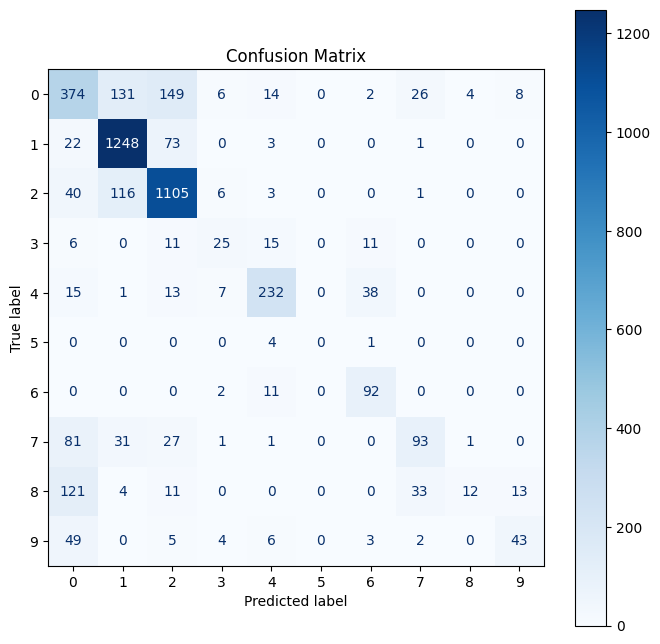

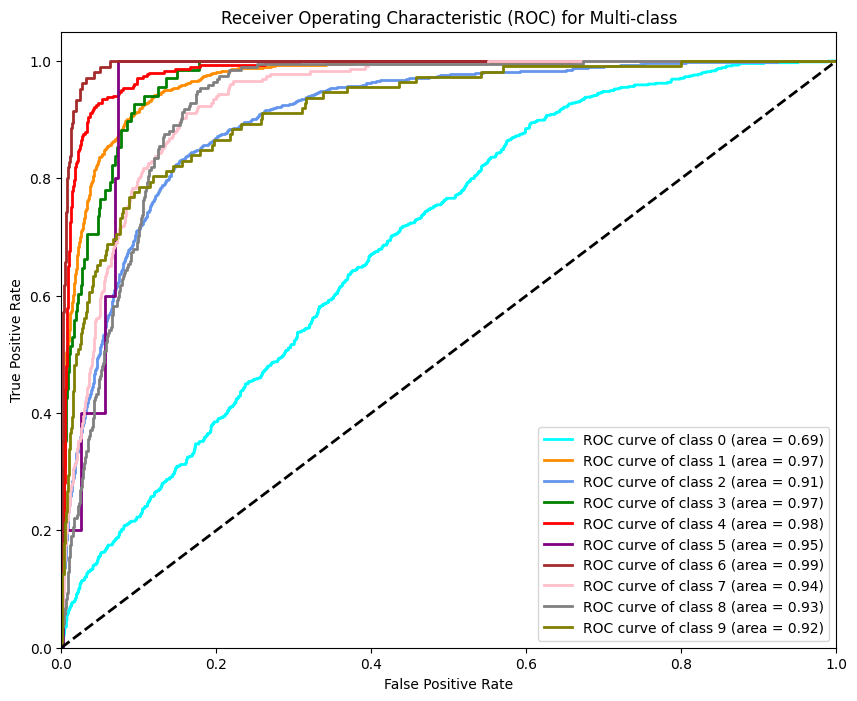

In [34]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle

import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []
all_scores = [] # For ROC curve, store raw scores (probabilities or logits)

with torch.no_grad(): # Disable gradient calculations
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_scores.extend(outputs.cpu().numpy()) # Store raw scores

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_scores = np.array(all_scores)

# Calculate accuracy
correct = (all_predictions == all_labels).sum()
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curves for each class
# Binarize the labels
y_true_binarized = label_binarize(all_labels, classes=np.arange(10))
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
                'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-class')
plt.legend(loc="lower right")
plt.show()